In [1]:
import numpy as np
import pandas as pd
import os,gc

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")
%matplotlib inline

In [2]:
trading_date = pd.read_csv('../data/trading_date.csv',names=['day'])
trading_date = trading_date[19:619].reset_index(drop=True)
trading_date['dd'] = range(len(trading_date))
trading_date.shape

(600, 2)

In [3]:
cols = ['fund_pair']
for i in range(400):
    cols.append(str(i))
train_correlation = pd.read_csv('../data/train_correlation.csv')
train_correlation.columns = cols
for i in range(400):
    train_correlation[str(i)] = train_correlation[str(i)].astype('float32')

In [4]:
cols = ['fund_pair']
for i in range(400,539):
    cols.append(str(i))
test_correlation = pd.read_csv('../data/test_correlation.csv')
test_correlation.columns = cols
for i in range(400,539):
    test_correlation[str(i)] = test_correlation[str(i)].astype('float32')

In [5]:
train_correlation = train_correlation.merge(test_correlation,on=['fund_pair'],how='left')
del test_correlation
gc.collect()
train_correlation.shape

(261003, 540)

In [6]:
num_pairs = train_correlation.shape[0]

In [7]:
fund_pair = train_correlation[['fund_pair']].copy()
fund_pair['fund0'] = fund_pair['fund_pair'].apply(lambda x:int(str(x).split('-')[0].split()[1]))
fund_pair['fund1'] = fund_pair['fund_pair'].apply(lambda x:int(str(x).split('-')[1].split()[1]))

In [8]:
cols = ['fund']
for i in range(400):
    cols.append(str(i))
train_fund_return = pd.read_csv('../data/train_fund_return.csv')
train_fund_benchmark_return = pd.read_csv('../data/train_fund_benchmark_return.csv')
train_fund_return.columns = cols
train_fund_benchmark_return.columns = cols

cols = ['fund']
for i in range(400,600):
    cols.append(str(i))
test_fund_return = pd.read_csv('../data/test_fund_return.csv')
test_fund_benchmark_return = pd.read_csv('../data/test_fund_benchmark_return.csv')
test_fund_return.columns = cols
test_fund_benchmark_return.columns = cols

train_fund_return = train_fund_return.merge(test_fund_return,on=['fund'],how='left')
train_fund_benchmark_return = train_fund_benchmark_return.merge(test_fund_benchmark_return,on=['fund'],how='left')
del test_fund_return,test_fund_benchmark_return
gc.collect()
print (train_fund_return.shape,train_fund_benchmark_return.shape)

(723, 601) (723, 601)


In [9]:
cols = []
for i in range(0,600):
    cols.append(str(i))
train_data2 = train_fund_return[cols].values
train_data3 = train_fund_benchmark_return[cols].values

In [10]:
cols = ['idx']
for i in range(400):
    cols.append(str(i))
train_index_return = pd.read_csv('../data/train_index_return.csv',encoding='GB2312')
train_index_return.columns = cols

cols = ['idx']
for i in range(400,600):
    cols.append(str(i))
test_index_return = pd.read_csv('../data/test_index_return.csv',encoding='GB2312')
test_index_return.columns = cols

train_index_return = train_index_return.merge(test_index_return,on=['idx'],how='left')
del test_index_return
gc.collect()
print (train_index_return.shape)

(35, 601)


In [11]:
cols = []
for i in range(600):
    cols.append(str(i))
index_return = train_index_return[cols].values*10
print (np.mean(np.mean(index_return)))
print (np.min(np.min(index_return)))
print (np.max(np.max(index_return)))

0.003286684394535658
-0.8916716949699199
0.79651343746725


In [12]:
input_len = 100
output_len = 61
output_len1 = input_len+output_len

In [13]:
val_ids = fund_pair[['fund0','fund1']].values
val_ids.shape

(261003, 2)

In [14]:
val_X_cols = []
for i in range(539-input_len-output_len,539-output_len):
    val_X_cols.append(str(i))
val_y_cols = []
for i in range(539-output_len,539):
    val_y_cols.append(str(i))
    
val_Y = train_correlation[val_y_cols].values.reshape(num_pairs,output_len,1)

In [15]:
val_X = np.zeros((num_pairs,input_len,1))
val_X[:,:,0] = train_correlation[val_X_cols].values

In [16]:
print (np.mean(np.mean(train_data2)))
print (np.min(np.min(train_data2)))
print (np.max(np.max(train_data2)))

print (np.mean(np.mean(train_data3)))
print (np.min(np.min(train_data3)))
print (np.max(np.max(train_data3)))

0.0004608952336021196
-0.099565106165259
0.45146573480877505
0.00030221792565278004
-0.11545913369641699
0.07343425126393101


In [17]:
val_X2 = np.zeros((num_pairs,output_len1,2))
val_X3 = np.zeros((num_pairs,output_len1,2))
test_X2 = np.zeros((num_pairs,output_len1,2))
test_X3 = np.zeros((num_pairs,output_len1,2))
for i in range(num_pairs):
    val_X2[i,:,0] = train_data2[val_ids[i,0]-1,539-output_len1:539]
    val_X2[i,:,1] = train_data3[val_ids[i,0]-1,539-output_len1:539]
    
    val_X3[i,:,0] = train_data2[val_ids[i,1]-1,539-output_len1:539]
    val_X3[i,:,1] = train_data3[val_ids[i,1]-1,539-output_len1:539]
    
    test_X2[i,:,0] = train_data2[val_ids[i,0]-1,600-output_len1:600]
    test_X2[i,:,1] = train_data3[val_ids[i,0]-1,600-output_len1:600]
    
    test_X3[i,:,0] = train_data2[val_ids[i,1]-1,600-output_len1:600]
    test_X3[i,:,1] = train_data3[val_ids[i,1]-1,600-output_len1:600]

In [18]:
val_idx = index_return[:,539-output_len1:539]
val_idx = np.swapaxes(val_idx, 0,1)
val_idx = np.expand_dims(val_idx,0)
val_idx = np.repeat(val_idx,num_pairs,axis=0)
val_idx.shape

(261003, 161, 35)

In [19]:
test_X_cols = []
for i in range(600-output_len-input_len,600-output_len):
    test_X_cols.append(str(i))
    
test_X = np.zeros((num_pairs,input_len,1))
test_X[:,:,0] = train_correlation[test_X_cols].values

In [20]:
test_idx = index_return[:,600-output_len1:600]
test_idx = np.swapaxes(test_idx, 0,1)
test_idx = np.expand_dims(test_idx,0)
test_idx = np.repeat(test_idx,num_pairs,axis=0)
test_idx.shape

(261003, 161, 35)

In [21]:
import keras
import tensorflow as tf
from keras import backend as K
from keras.layers import *
from keras.models import Model
from keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau

from keras.layers.embeddings import Embedding
from keras.layers.core import Layer

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [22]:
np.random.seed(555)
class DataGenerator(keras.utils.Sequence):
    def __init__(self, data, ids_data,index_return_data,data2,data3,
                 batch_size=512, am = 1, alen=100, blen=61, clen=100,shuffle=True):
        self.batch_size = batch_size
        self.am = am
        self.data = data
        self.data2 = data2
        self.data3 = data3
        self.index_return_data = index_return_data
        self.ids_data = ids_data
        self.alen = alen
        self.blen = blen
        self.clen = clen
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.data) / self.batch_size))*self.am+1

    def __getitem__(self, index):
        #indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        indexes = np.array(range(index*self.batch_size,(index+1)*self.batch_size))
        indexes = indexes%len(self.data)
        indexes = self.indexes[indexes]
        X, y = self.__data_generation(indexes)
        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.data))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, indexes):
        X = np.empty((self.batch_size, self.alen, 1))
        y = np.empty((self.batch_size, self.blen, 1))
        X1 = np.empty((self.batch_size, self.clen,35))
        ids = np.empty((self.batch_size, 2))
        x2 = np.empty((self.batch_size, self.clen, 2))
        x3 = np.empty((self.batch_size, self.clen, 2))

        for i in range(len(indexes)):
            si = np.random.randint(0,539-self.blen-self.blen-self.alen)
            X[i,:,0] = self.data[indexes[i],si:si+self.alen]
            
            y[i,:,0] = self.data[indexes[i],si+self.alen:si+self.alen+self.blen]
            X1[i,:,:] = np.swapaxes(self.index_return_data[:,si+self.alen+self.blen-self.clen:si+self.alen+self.blen],0,1)
            ids[i,:] = self.ids_data[indexes[i],:]
            x2[i,:,0] = self.data2[self.ids_data[indexes[i],0]-1,si+self.alen+self.blen-self.clen:si+self.alen+self.blen]
            x2[i,:,1] = self.data3[self.ids_data[indexes[i],0]-1,si+self.alen+self.blen-self.clen:si+self.alen+self.blen]
            
            x3[i,:,0] = self.data2[self.ids_data[indexes[i],1]-1,si+self.alen+self.blen-self.clen:si+self.alen+self.blen]
            x3[i,:,1] = self.data3[self.ids_data[indexes[i],1]-1,si+self.alen+self.blen-self.clen:si+self.alen+self.blen]

        return [ids,X,X1,x2,x3],y

In [23]:
train_cols = []
for i in range(0,539):
    train_cols.append(str(i))
train_data = train_correlation[train_cols].values

In [ ]:
params = {'batch_size': 512,
          'alen': input_len,
          'blen': output_len,
          'clen': output_len1,
          'am':1,
          'shuffle': True}


training_generator = DataGenerator(train_data,val_ids,index_return,train_data2,train_data3,  **params)

In [24]:
print (np.mean(np.mean(train_data)))
print (np.min(np.min(train_data)))
print (np.max(np.max(train_data)))

0.7673176
-0.43738315
0.9999626


In [25]:
(np.array([-0.43738315,0.9999626])-0.7673176+1.3)/1.6

array([0.05956203, 0.95790312])

In [24]:
from keras import backend as K
from keras.layers import Layer
from keras import initializers, regularizers, constraints
 
def dot_product(x, kernel):
    """
    Wrapper for dot product operation, in order to be compatible with both
    Theano and Tensorflow
    Args:
        x (): input
        kernel (): weights
    Returns:
    """
    if K.backend() == 'tensorflow':
        return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
        return K.dot(x, kernel)

class AttentionWithContext(Layer):
    """
    Attention operation, with a context/query vector, for temporal data.
    Supports Masking.
    Follows the work of Yang et al. [https://www.cs.cmu.edu/~diyiy/docs/naacl16.pdf]
    "Hierarchical Attention Networks for Document Classification"
    by using a context vector to assist the attention
    # Input shape
        3D tensor with shape: `(samples, steps, features)`.
    # Output shape
        2D tensor with shape: `(samples, features)`.
    How to use:
    Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
    The dimensions are inferred based on the output shape of the RNN.
    Note: The layer has been tested with Keras 2.0.6
    Example:
        model.add(LSTM(64, return_sequences=True))
        model.add(AttentionWithContext())
        # next add a Dense layer (for classification/regression) or whatever...
    """
 
    def __init__(self,
                 W_regularizer=None, u_regularizer=None, b_regularizer=None,
                 W_constraint=None, u_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
 
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')
 
        self.W_regularizer = regularizers.get(W_regularizer)
        self.u_regularizer = regularizers.get(u_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)
 
        self.W_constraint = constraints.get(W_constraint)
        self.u_constraint = constraints.get(u_constraint)
        self.b_constraint = constraints.get(b_constraint)
 
        self.bias = bias
        super(AttentionWithContext, self).__init__(**kwargs)
 
    def build(self, input_shape):
        assert len(input_shape) == 3
 
        self.W = self.add_weight((input_shape[-1], input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight((input_shape[-1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
 
        self.u = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_u'.format(self.name),
                                 regularizer=self.u_regularizer,
                                 constraint=self.u_constraint)
 
        super(AttentionWithContext, self).build(input_shape)
 
    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None
 
    def call(self, x, mask=None):
        uit = dot_product(x, self.W)
 
        if self.bias:
            uit += self.b
 
        uit = K.tanh(uit)
        ait = dot_product(uit, self.u)
 
        a = K.exp(ait)
 
        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())
 
        # in some cases especially in the early stages of training the sum may be almost zero
        # and this results in NaN's. A workaround is to add a very small positive number ε to the sum.
        # a /= K.cast(K.sum(a, axis=1, keepdims=True), K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())
 
        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)
 
    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[-1]

In [27]:
class get_diff_seq(Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, x):
        y = []
        y.append(x[:,0:1,:])
        for i in range(1,x.shape[1]):
            y.append(x[:,i:i+1,:]-x[:,i-1:i,:])
        y = Concatenate(axis=1)(y)
        return y

    def compute_output_shape(self, input_shape):
        return (input_shape)

class get_add_seq(Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, x):
        y = []
        y.append(x[:,0:1,:])
        for i in range(1,x.shape[1]):
            y.append(x[:,i:i+1,:]+y[i-1])
        y = Concatenate(axis=1)(y)
        return y

    def compute_output_shape(self, input_shape):
        return (input_shape)

def get_basemodel(x_id,x,out_x,out_x1,out_x2):  
    #x_id = Lambda(lambda x:K.expand_dims(x,1))(x_id)
    temp = Lambda(lambda x:x[:,input_len-1,:input_len])(x)
    in_temp = RepeatVector(input_len)(temp)
    out_temp = RepeatVector(output_len)(temp)
    x = Lambda(lambda x:x[0]-x[1])([x,in_temp])
    
    x = get_diff_seq()(x)
    x = Lambda(lambda x:x[:,1:,:])(x)
    
    x_id = Embedding(724,16,input_length=2)(x_id)
    x_id = Lambda(lambda x:x[:,0,:]*x[:,1,:])(x_id)
    #x_id_in = RepeatVector(input_len)(x_id)
    x_id_out = RepeatVector(output_len)(x_id)

    
    hdn1 = 32
    rnn1 = GRU(hdn1,return_sequences=True,dropout=0.5,recurrent_dropout=0.5,)
    out1_ = rnn1(out_x1)
    out2_ = rnn1(out_x2)
    diff = Lambda(lambda x: K.abs(x[0] * x[1]))([out1_,out2_])
    #in_diff = Lambda(lambda x:x[:,:output_len1-output_len,:])(diff)
    out_diff = Lambda(lambda x:x[:,output_len1-output_len:,:])(diff)
    #out_diff = RepeatVector(output_len)(diff)
    
    hdn2 = 64
    rnn2 = GRU(hdn2,return_sequences=True,dropout=0.5,recurrent_dropout=0.5, )
    out3_ = rnn2(out_x)
    #in_idx = Lambda(lambda x:x[:,:output_len1-output_len,:])(out3_)
    out_idx = Lambda(lambda x:x[:,output_len1-output_len:,:])(out3_)
    #out_idx = RepeatVector(output_len)(out3_)

    
    hdn3 = 256
    rnn3 = GRU(hdn3,return_state=True,return_sequences=True,
                  #kernel_initializer='Orthogonal',
                  #bias_initializer='zeros', 
                  #kernel_regularizer=keras.regularizers.l2(0.0001), 
                  #recurrent_regularizer=keras.regularizers.l2(0.0001),
                  dropout=0.5, 
                  recurrent_dropout=0.5,
                 )
    de_rnn3 = GRU(hdn3, return_sequences=True, return_state=True,
                   #kernel_initializer='Orthogonal',
                   #bias_initializer='zeros', 
                   #kernel_regularizer=keras.regularizers.l2(0.0001), 
                   #recurrent_regularizer=keras.regularizers.l2(0.0001),
                   dropout=0.5, 
                   recurrent_dropout=0.5,
                  )
    
    #x = Concatenate(axis=2)([x_id_in, x, in_diff, in_idx])
    xx = Concatenate(axis=2)([x_id_out, out_diff, out_idx])
    #xx = Concatenate(axis=1)([x_id, diff, out3_])
    #xx = Dense(128,kernel_initializer='he_normal')(xx)
    #xx = BatchNormalization()(xx)
    #xx = PReLU()(xx)
    #xx = Dropout(0.5)(xx)
    #xx = RepeatVector(output_len)(xx)
    
    out4_,state4 = rnn3(x)
    out_x_4,_ = de_rnn3(xx,initial_state=state4)
    
    
    y = out_x_4
    #y = Dropout(0.5)(y)
    
    #y = Dense(128,kernel_initializer='he_normal')(y)
    #y = BatchNormalization()(y)
    #y = PReLU()(y)
    y = Dropout(0.5)(y)
    y = Dense(1,kernel_initializer='he_normal',activation='tanh')(y)
    y = Lambda(lambda xx:xx*0.1)(y)
    y = get_add_seq()(y)
    y = add([y,out_temp])
    #y = Lambda(lambda xx:xx*1.6-1.3+0.7673176)(y)
    
    return y

ids = Input(shape=(2, ))
seq_in = Input(shape=(input_len, 1))
out_x = Input(shape=(output_len1, 35))
out_x1 = Input(shape=(output_len1, 2))
out_x2 = Input(shape=(output_len1, 2))
seq_out = get_basemodel(ids,seq_in,out_x,out_x1,out_x2)
model = Model([ids,seq_in,out_x,out_x1,out_x2],seq_out)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 100, 1)       0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 1)            0           input_2[0][0]                    
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 2)            0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 161, 2)       0                                            
__________________________________________________________________________________________________
input_5 (I

In [35]:
def lc_loss(y_true, y_pred):  
    y_true = y_true[:,:,0]
    y_pred = y_pred[:,:,0]
    MAE = K.mean(K.abs(y_pred - y_true), axis=-1)   
    TMAPE = K.mean(K.abs(y_pred-y_true)/(1.5-y_true), axis=-1)  
    
    y_true1 = y_true[:,50:61]
    y_pred1 = y_pred[:,50:61]
    MAE1 = K.mean(K.abs(y_pred1 - y_true1), axis=-1)   
    TMAPE1 = K.mean(K.abs(y_pred1-y_true1)/(1.5-y_true1), axis=-1) 
    
    return MAE + TMAPE + (MAE1 + TMAPE1)


In [29]:
def lc_metric(y_true, y_pred):
    y_true = y_true[:,:,0]
    y_pred = y_pred[:,:,0]
    MAE = K.mean(K.abs(y_pred-y_true), axis=-1)   
    TMAPE = K.mean(K.abs(y_pred-y_true)/(1.5-y_true), axis=-1)  
    return (2/(2+MAE+TMAPE))**2

In [36]:
def lc_metric1(y_true, y_pred):
    y_true = y_true[:,50:61,0]
    y_pred = y_pred[:,50:61,0]
    MAE = K.mean(K.abs(y_pred-y_true), axis=-1)   
    TMAPE = K.mean(K.abs(y_pred-y_true)/(1.5-y_true), axis=-1)  
    return (2/(2+MAE+TMAPE))**2

In [ ]:
params = {'batch_size': 512*2,
          'alen': input_len,
          'blen': output_len,
          'clen': output_len1,
          'am':1,
          'shuffle': True}

training_generator = DataGenerator(train_data,val_ids,index_return,train_data2,train_data3,  **params)


In [37]:
ids = Input(shape=(2, ))
seq_in = Input(shape=(input_len, 1))
out_x = Input(shape=(output_len1, 35))
out_x1 = Input(shape=(output_len1, 2))
out_x2 = Input(shape=(output_len1, 2))
seq_out = get_basemodel(ids,seq_in,out_x,out_x1,out_x2)
model = Model([ids,seq_in,out_x,out_x1,out_x2],seq_out)

In [38]:

early_stopping = EarlyStopping(patience=6,
                               verbose=1,
                               monitor='val_lc_metric',
                               mode='max',
                              )
model_checkpoint = ModelCheckpoint("../data/keras.model",
                                   save_best_only=True,
                                   verbose=1,
                                   monitor='val_lc_metric',
                                   mode='max',
                                  )
reduce_lr = ReduceLROnPlateau(factor=0.1, 
                              patience=2, 
                              min_lr=0.00001, 
                              verbose=1,
                              monitor='val_lc_metric',
                              mode='max',
                             )

model.compile(
              #loss='mse', 
              loss=lc_loss,
              optimizer=keras.optimizers.Nadam(lr=0.0002),
              metrics=[lc_metric,lc_metric1],
             )

epochs = 100
batch_size = 512
model.fit_generator(generator=training_generator,
                    validation_data=[[val_ids,val_X,val_idx,val_X2,val_X3],val_Y],
                    epochs=epochs,
                    #batch_size=batch_size,
                    callbacks=[early_stopping, model_checkpoint, reduce_lr],
                    #use_multiprocessing=False,
                    #workers=1,
                   )


Epoch 1/100
255/255 [==============================] - 286s 1s/step - loss: 0.3352 - lc_metric: 0.8812 - lc_metric1: 0.8397 - val_loss: 0.4689 - val_lc_metric: 0.8583 - val_lc_metric1: 0.7752

Epoch 00001: val_lc_metric improved from -inf to 0.85832, saving model to ../data/keras.model
Epoch 2/100
255/255 [==============================] - 282s 1s/step - loss: 0.3301 - lc_metric: 0.8828 - lc_metric1: 0.8419 - val_loss: 0.4469 - val_lc_metric: 0.8653 - val_lc_metric1: 0.7833

Epoch 00002: val_lc_metric improved from 0.85832 to 0.86529, saving model to ../data/keras.model
Epoch 3/100
255/255 [==============================] - 281s 1s/step - loss: 0.3279 - lc_metric: 0.8836 - lc_metric1: 0.8429 - val_loss: 0.4453 - val_lc_metric: 0.8651 - val_lc_metric1: 0.7844

Epoch 00003: val_lc_metric did not improve from 0.86529
Epoch 4/100
255/255 [==============================] - 281s 1s/step - loss: 0.3268 - lc_metric: 0.8839 - lc_metric1: 0.8434 - val_loss: 0.4438 - val_lc_metric: 0.8656 - val_l

In [ ]:
0.87544 0.7903


In [ ]:
0.85859

In [39]:
model.load_weights("../data/keras.model")

In [40]:

y_pred = model.predict([val_ids,test_X,test_idx, test_X2,test_X3],batch_size = 512)

In [41]:
y_pred.shape

(261003, 61, 1)

In [42]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")
%matplotlib inline

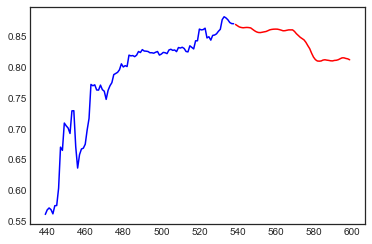

In [48]:
ii = 11000
plt.plot(range(439,539),train_data[ii,439:],color='blue')
plt.plot(range(539,539+61),y_pred[ii,:],color='red')

In [9]:
train_correlation.columns

Index(['fund_pair', '0', '1', '2', '3', '4', '5', '6', '7', '8',
       ...
       '529', '530', '531', '532', '533', '534', '535', '536', '537', '538'],
      dtype='object', length=540)

In [6]:
sub = pd.DataFrame()
sub['ID'] = train_correlation['fund_pair']
#sub['value'] = np.mean(y_pred[:,50:61,0],axis=1)
uuu = ['538','111','222','333','444','66','88','528','518']
#uuu = ['66','88','528','518']
sub['value'] = np.mean(np.array(train_correlation[uuu].values),axis=1)

In [7]:
sub.to_csv('../submit/1111_random.csv',index=None)

In [8]:
sub['value'].describe()

count    261003.000000
mean          0.831386
std           0.085967
min           0.106672
25%           0.792284
50%           0.850266
75%           0.891611
max           0.999556
Name: value, dtype: float64